<a href="https://colab.research.google.com/github/worker2396/AGH/blob/main/Czesc2_2022_Odkrywanie_modeli_BPMN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Odkrywanie modeli procesów w BPMN przy użyciu dostosowanego do notacji BPMN algorytmu Alpha Miner

Na tym etapie projektu omówimy proste rozwiązanie z zakresu odkrywania modeli procesów -- na potrzeby zrozumienia sposobu odkrywania bram zastosujemy nieco zmieniony algorytm Alpha przystosowany do odkrywania modeli w notacji BPMN.

Elementy tego rozwiązania powinny zostać zintegrowane z rozwiązaniem z poprzednich ćwiczeń.

## Konfiguracja środowiska

Przed implementacją potrzebujemy jeszcze odpowiednie środowisko:

In [68]:
import pygraphviz as pgv
from itertools import product
from collections import defaultdict
from typing import Dict, Set
from IPython.display import Image, display
import pandas as pd
from pm4py.objects.conversion.log import converter as xes_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

## Przykładowy log dla zrozumienia działania algorytmu

Rozważmy następujące ślady (warianty) pewnego dziennika zdarzeń:

```
a b c d e g
a b c d f g 
a c b d e g
a c b d f g
```

Dla takiego zbioru wariantów, w oparciu o algorytm Alpha, możemy znaleźć następujące relacje (x,y — zdarzenia):

* (>) **następstwo bezpośrednie**: x>y jeśli w dowolnym wariancie bezpośrednim następstwem zdarzenia x jest zdarzenie y,
* (→) **przyczynowość**: x→y iff x>y & not y>x,
* (||) **potencjalna równoległość**: x||y iff x>y & y>x,
* (#) **wybór/niepowiązanie/brak bezpośredniego następstwa**: x#y iff not x>y & not y>x.

W naszej implementacji nie musimy używać bezpośrednio relacji **brak bezpośredniego następstwa**, gdyż zamiast tego wystarczy sprawdzić, czy dane zdarzenia nie są w jednej z relacji: **przyczynowość** lub **potencjalna równoległość**.


## Manualne określenie relacji

Analogicznie jak na poprzednim laboratorium należy określić zbiory zdarzeń początkowych oraz końcowych:

In [69]:
file = input()
start_set_events = set()
end_set_events = set()
if file.endswith('.csv'):
    df = pd.read_csv(file)
    data = {1: 0,
    2: 0,
    3: 0,
    4: 0}
    for case in df['Case ID']:
        if help == case: 
            continue
        df1 = df.loc[df['Case ID'] == case]
        # print(df1)
        df1 = df1["Activity"].values.tolist()
        help = case
        data[case] = df1
elif file.endswith('.xes'):
    log = xes_importer.apply(file)
    pd = xes_converter.apply(log, variant=xes_converter.TO_DATA_FRAME)
    df = pd
    data = {}
    for case in df['case:concept:name']:
        if help == case: 
                continue
        df1 = df.loc[df['case:concept:name'] == case]
        df1 = df1["Activity"].values.tolist()
        help = case
        data[case] = df1
elif file == 'test':
    data ={1: ['a', 'b', 'c', 'd', 'e', 'h', 'i', 'k'], 
2: ['a', 'b', 'd', 'c', 'e', 'h', 'j', 'k'],
3: ['a', 'f', 'g', 'h', 'i', 'k']}       

print(data)

for key, lists in data.items():
    start_set_events.update(set(lists[0]))
    end_set_events.update(set(lists[-1]))
print(start_set_events)
print(end_set_events)
print(type(data))

parsing log, completed traces :: 100%|██████████| 4/4 [00:00<00:00, 3997.43it/s]

{'1': ['b', 'c', 'd', 'e'], '2': ['b', 'c', 'e', 'd'], '3': ['a', 'c', 'd', 'e'], '4': ['a', 'c', 'e', 'd']}
{'b', 'a'}
{'d', 'e'}
<class 'dict'>


Następnie określimy relacje, tak jak zdefiniowano w algorytmie Alpha:

In [70]:
def get_direct_succession(Data):
    direct_s = dict()
    value_s = []
    for key, value in Data.items():
        for i, l in enumerate(value):
            if l in direct_s.keys():
                try:
                    direct_s[l].update(set(value[i+1]))
                except:
                    continue
            else:
                try:
                    direct_s[l] = set(value[i+1])
                except:
                    print("LOL")
    return direct_s
direct_s = get_direct_succession(data)
direct_s

LOL


{'b': {'c'}, 'c': {'d', 'e'}, 'd': {'e'}, 'e': {'d'}, 'a': {'c'}}

Na bazie powyższych relacji oraz poniższych wzorców postaramy się zbudować model procesu w notacji BPMN:
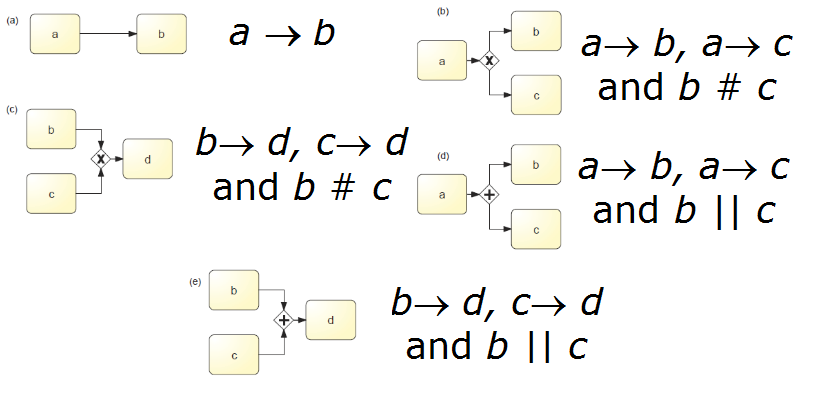


Na potrzeby naszej implementacji możemy również zdefiniować odwróconą przyczynowość dla tych zdarzeń w relacji przyczynowości, które mają wspólną przyczynę (nie jest to część samego algorytmu alfa, ale może być pomocne jako zmienna tymczasowa przy korzystaniu z wzorców alfa mining):

In [71]:
def get_causality(direct_s) -> Dict[str, Set[str]]:
    causality = defaultdict(set)
    for ev_cause, events in direct_s.items():
        for event in events:
            if ev_cause not in direct_s.get(event, set()):
                causality[ev_cause].add(event)
    return dict(causality)

In [72]:
causality = get_causality(direct_s)
causality

{'b': {'c'}, 'c': {'d', 'e'}, 'a': {'c'}}

In [73]:
keys = list()
for key, value in direct_s.items():
    keys.append(key)
parallel_events = set()
lista = list()
# set(keys)
keys.sort()
for i, keyss in enumerate(keys):
        if i < (len(keys)-1):
            if (keys[i]) in (direct_s[keys[i+1]]) and (keys[i+1]) and (direct_s[keys[i]]):
                tuplez = (keys[i], keys[i+1])

                parallel_events.update([tuplez])

listas = list(parallel_events)
set1 = set()
set2 = set()
set3 = set()
setss = [set1, set2, set3]
for i, listass in enumerate(listas):
    for j, vals in enumerate(listass):
        if listass[j] in listas[i] and i != j:
            print(listass[j], listas[i])
            setss[i] = set(listas[i])

            set1.update((setss[i]))
parallel_events.update([tuple(set1)])
parallel_events

e ('d', 'e')


{('d', 'e')}

In [74]:
def get_inv_causality(direct_s) -> Dict[str, Set[str]]:
    inv_causality = defaultdict(set)
    for key, values in causality.items():
        for value in values: 
          inv_causality[value].add(key)
    return {k: v for k, v in inv_causality.items() if len(v) > 1}

In [75]:
inv_causality = get_inv_causality(causality)
inv_causality

{'c': {'a', 'b'}}

## Wyświetlenie prostego modelu BPMN

Poniżej zaprezentowano przykładowy kod umożliwiający wyświetlenie modelu z użyciem podstawowych elementów BPMN:

C:\Users\Filip\anaconda3\envs\Modelowanie\lib\site-packages\pygraphviz\agraph.py:1402: RuntimeWarning: Warning: Could not load "C:\Users\Filip\anaconda3\envs\Modelowanie\Library\bin\gvplugin_pango.dll" - It was found, so perhaps one of its dependents was not.  Try ldd.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


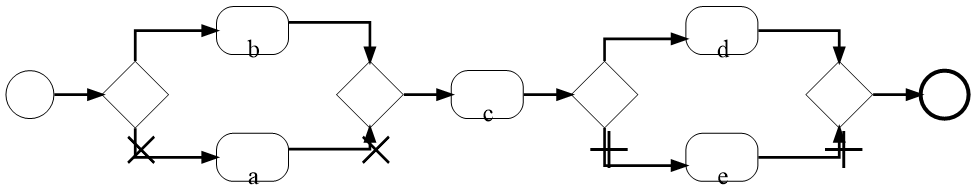

In [76]:
class MyGraph(pgv.AGraph):
 
    def __init__(self, *args):
        super(MyGraph, self).__init__(strict=False, directed=True, *args)
        self.graph_attr['rankdir'] = 'LR'
        self.node_attr['shape'] = 'Mrecord'
        self.graph_attr['splines'] = 'ortho'
        self.graph_attr['nodesep'] = '0.8'
        self.edge_attr.update(penwidth='2')
 
    def add_event(self, name):
        super(MyGraph, self).add_node(name, shape="circle", label="")
 
    def add_end_event(self, name):
        super(MyGraph, self).add_node(name, shape="circle", label="",penwidth='3')

    def add_and_gateway(self, *args):
        super(MyGraph, self).add_node(*args, shape="diamond",
                                  width=".7",height=".7",
                                  fixedsize="true",
                                  fontsize="40",label="+")
 
    def add_xor_gateway(self, *args, **kwargs):
        super(MyGraph, self).add_node(*args, shape="diamond",
                                  width=".7",height=".7",
                                  fixedsize="true",
                                  fontsize="40",label="×")
 
    def add_and_split_gateway(self, source, targets, *args):
        gateway = 'ANDs '+str(source)+'->'+str(targets)        
        self.add_and_gateway(gateway,*args)
        super(MyGraph, self).add_edge(source, gateway)
        for target in targets:
            super(MyGraph, self).add_edge(gateway, target)
 
    def add_xor_split_gateway(self, source, targets, *args):
        gateway = 'XORs '+str(source)+'->'+str(targets) 
        self.add_xor_gateway(gateway, *args)
        super(MyGraph, self).add_edge(source, gateway)
        for target in targets:
            super(MyGraph, self).add_edge(gateway, target)
 
    def add_and_merge_gateway(self, sources, target, *args):
        gateway = 'ANDm '+str(sources)+'->'+str(target)
        self.add_and_gateway(gateway,*args)
        super(MyGraph, self).add_edge(gateway,target)
        for source in sources:
            super(MyGraph, self).add_edge(source, gateway)
 
    def add_xor_merge_gateway(self, sources, target, *args):
        gateway = 'XORm '+str(sources)+'->'+str(target)
        self.add_xor_gateway(gateway, *args)
        super(MyGraph, self).add_edge(gateway,target)
        for source in sources:
            super(MyGraph, self).add_edge(source, gateway)

G = MyGraph()

# adding start event
G.add_event("start")
if len(start_set_events) > 1:
    if tuple(start_set_events) in parallel_events: 
        G.add_and_split_gateway("start",start_set_events)
    else:
        G.add_xor_split_gateway("start",start_set_events)
else: 
    G.add_edge("start",list(start_set_events)[0])

# adding split gateways based on causality
for event in causality:
    if len(causality[event]) > 1:
        if tuple(causality[event]) in parallel_events:        
            G.add_and_split_gateway(event,causality[event])
        else:
            G.add_xor_split_gateway(event,causality[event])
 
# adding merge gateways based on inverted causality
for event in inv_causality:
    if len(inv_causality[event]) > 1:
        if tuple(inv_causality[event]) in parallel_events:
            G.add_and_merge_gateway(inv_causality[event],event)
        else:
            G.add_xor_merge_gateway(inv_causality[event],event)
    elif len(inv_causality[event]) == 1:
        source = list(inv_causality[event])[0]
        G.add_edge(source,event)

# adding end event
G.add_end_event("end")
if len(end_set_events) > 1:
    if tuple(end_set_events) in parallel_events: 
        G.add_and_merge_gateway(end_set_events,"end")
    else:
        G.add_xor_merge_gateway(end_set_events,"end")    
else: 
    G.add_edge(list(end_set_events)[0],"end")

G.draw('simple_process_model.png', prog='dot')
display(Image('simple_process_model.png'))

## Ćwiczenia rozszerzające model

1. Dopisz odpowiednie fragmenty kodu, tak aby móc uzyskać odpowiednie zbiory zdarzeń i relacje automatycznie. Sprawdź wynik dla poniższego przykładowego zbioru wariantów:

```
a b c d e h i k 
a b d c e h j k 
a f g h i k
```

```
direct_succession = {
    'a': {'b', 'f'},
    'b': {'c', 'd'},
    'c': {'d', 'e'},
    'd': {'c', 'e'},
    'e': {'h'},
    'f': {'g'},
    'g': {'h'},
    'h': {'i', 'j'},
    'i': {'k'},
    'j': {'k'}
}
```
2. Zastanów się nad uogólnieniem relacji na wiele zdarzeń, tzn. jak powinny być wykrywane bramy posiadające wiele przepływów wejściowych lub wiele przepływów wyjściowych, a także co w przypadku, gdy relacje dla wielu zdarzeń są różne.

  * Przetestuj swoje rozwiązanie na zestawie prostszych logów (zestaw A), które zostaną udostępnione na MS Teams. W sprawozdaniu proszę zamieścić wyniki działania rozwiązania dla całego zestawu.

3. Zintegruj odkrywanie relacji z dzisiejszych zajęć z minerem stworzonym w ramach poprzednich zajęć i rozszerz ich działanie. 

  * Przemyśl między innymi, jak powinno zachowywać się filtrowanie w przypadku wykrywanych relacji. 

  * Uwaga! Pamiętaj, że realne logi mogą dla algorytmu Alpha nie dawać sensownych rezultatów, ze względu na ograniczenia samego algorytmu. Ponadto przedstawiony sposób wizualizacji BPMN może być nieestetyczny w przypadku skomplikowanego układu bramek lub pętli.

4. Dodaj możliwość przesłania pliku dziennika zdarzeń w celu wykrycia procesu:

  * Automatyczne wykryj typ pliku logu (`csv`, `xes`) i załaduj odpowiednie dane z pliku. Plik `xes` w formacie XML można załadować np. biblioteką `opyenxes`.

  * W przypadku pliku `csv`, spróbuj dopasować ID przypadku, aktywność i znacznik czasu, lub jeśli nie są one dopasowane, poproś użytkownika o określenie odpowiednich kolumn.

5. Rozbuduj opracowany algorytm o wykrywanie dodatkowych relacji/konstrukcji z algorytmu Alpha+ (krótkie pętle: *self-loops* oraz *short-loops*). 

  * Przetestuj swoje rozwiązanie na zestawie prostszych logów (zestaw B), które zostaną udostępnione na MS Teams. W sprawozdaniu proszę zamieścić wyniki działania rozwiązania dla całego zestawu.

6. (*nadobowiązkowe*) Biblioteka używana do wizualizacji ma pewne ograniczenia, więc wyświetlany model BPMN nie zawsze będzie dobrze wyglądał. Osoby zainteresowane mogą zapoznać się z możliwościami rozbudowy swojego projektu poprzez:

  * Eksport diagramów BPMN w standaryzowanym formacie XML — można go zrealizować przy użyciu np. `bpmn-python` (https://github.com/KrzyHonk/bpmn-python).
  * Przygotowanie interaktywnej wizualizacji przy użyciu np. `pyvis` (https://pyvis.readthedocs.io/en/latest/index.html) albo `bpmn-js` (https://bpmn.io/toolkit/bpmn-js/).

Dzisiejszy temat jest przewidziany do realizacji przez 2 tygodnie zajęciowe, zatem kolejne zajęcia w marcu będą miały formę konsultacyjną. 

Zadania mogą być realizowane w parach, natomiast w sprawozdaniu należy podać wtedy imiona i nazwiska osób z pary oraz każda osoba powinna wysłać zadanie/sprawozdanie przez system MS Teams osobno. W sprawozdaniu należy umieścić odpowiednie zrzuty ekranu oraz kod źródłowy (fragment kodu ze zmianami). 
**Sprawozdanie z wykonanych ćwiczeń należy przesłać przez platformę MS Teams do 10.04.2021**. Sprawozdanie (pdf + kod w pliku py albo ipynb).


## Dodatkowe informacje

W razie potrzeby dodatkowych konsultacji proszę o informację lub ewentualne pytania e-mailowo, na messengerze albo na MS Teams. 

Dziękuję za udział w zajęciach! \\
Krzysztof Kluza \\
kluza@agh.edu.pl
